In [1]:
from typing import List, Dict, Tuple, Callable
import os
import gc
import traceback
import warnings
from pdb import set_trace

import sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def l1_norm(x: np.ndarray) -> float:
    """ Computes the L1 norm 

        Args:
            x: A 1D or 2D column vector 

        Return:
            A float corresponding to the L1 norm
    """
    lms = np.linalg.norm(x, 1)
    return lms

In [3]:
def squared_l2_norm(x: np.ndarray) -> float:
    """ Computes the squared L2 norm 

        Args:
            x: A 1D or 2D column vector 

        Return:
            A float corresponding to the squared L2 norm
    """
    ln = np.linalg.norm(x, ord=2)
    return ln**2

In [4]:
crop_df = pd.read_csv(r'C:\Users\hanna\Fall2024\ITCS3156\Projects\crop_yield.csv')

In [5]:
crop_df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 10 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   Region                  1000000 non-null  object 
 1   Soil_Type               1000000 non-null  object 
 2   Crop                    1000000 non-null  object 
 3   Rainfall_mm             1000000 non-null  float64
 4   Temperature_Celsius     1000000 non-null  float64
 5   Fertilizer_Used         1000000 non-null  bool   
 6   Irrigation_Used         1000000 non-null  bool   
 7   Weather_Condition       1000000 non-null  object 
 8   Days_to_Harvest         1000000 non-null  int64  
 9   Yield_tons_per_hectare  1000000 non-null  float64
dtypes: bool(2), float64(3), int64(1), object(4)
memory usage: 62.9+ MB


In [6]:
crop_df.describe()

,Rainfall_mm,Temperature_Celsius,Days_to_Harvest,Yield_tons_per_hectare
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,549.981901,27.504965,104.495025,4.649472
std,259.851320,7.220608,25.953412,1.696572
min,100.000896,15.000034,60.000000,-1.147613
25%,324.891090,21.254502,82.000000,3.417637
50%,550.124061,27.507365,104.000000,4.651808
75%,774.738520,33.753267,127.000000,5.879200
max,999.998098,39.999997,149.000000,9.963372


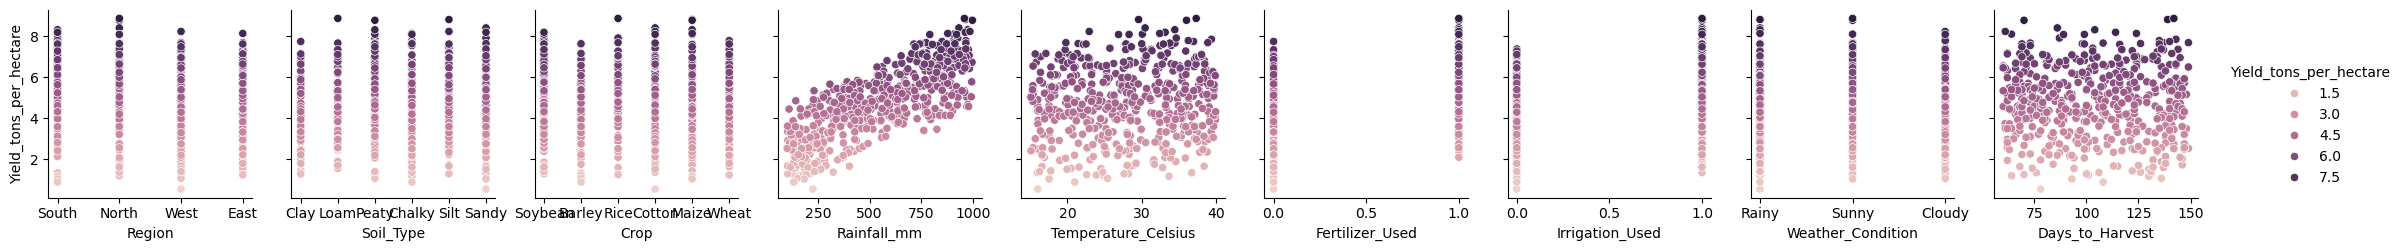

In [7]:
import seaborn as sns
rng = np.random.RandomState(0)
indices = rng.choice(np.arange(len(crop_df)), size=500, replace=False)
sns.pairplot(
    data=crop_df.iloc[indices],
    y_vars='Yield_tons_per_hectare',
    x_vars=list(crop_df.drop('Yield_tons_per_hectare',axis=1).columns),
    hue="Yield_tons_per_hectare",
)
plt.show()

In [8]:
crops_ohe = crop_df
categorical_columns = ['Region','Soil_Type','Crop','Fertilizer_Used','Irrigation_Used', 'Weather_Condition']
for col in categorical_columns:
    col_ohe = pd.get_dummies(crop_df[col], prefix=col)
    crops_ohe = pd.concat((crops_ohe, col_ohe), axis=1).drop(col, axis=1)

In [9]:
def poly_features(X: np.ndarray, degree: int) -> np.ndarray:
    """ Compute polynomial features for pass data

        Args:
            X: Matrix of input data for which polynomial features
                will be computed for.

            degree: The degree of the polynomial which will be computed.

        Return:
            A matrix containing the original data and the new polynomial data.
    """
   
    X_poly = X.copy()
    for i in range(2, degree+1):  
        x_stack = X**i
        X_poly = np.hstack([X_poly, x_stack]) 
    return X_poly

In [10]:
from sklearn.model_selection import train_test_split
def get_train_valid_test_data(
    X: np.ndarray, 
    y: np.ndarray, 
) -> Tuple[np.ndarray]:
    """ Randomizes and then splits the data into train, validation, and test sets.

        Args:
            X: Data given as a 2D matrix

            y: Labels given as a vector 
    """
    X_trn, y_trn, X_vld, y_vld, X_tst, y_tst= None, None, None, None, None, None
    X_trn,X_tst,y_trn, y_tst = train_test_split(X,y,test_size=0.2, random_state=42)
    X_trn, X_vld, y_trn, y_vld = train_test_split(X_trn,y_trn,test_size=0.2, random_state=42)
    return X_trn, y_trn, X_vld, y_vld, X_tst, y_tst

In [11]:
from sklearn import preprocessing
def get_preprocessed_data(degree: int)  -> Tuple[np.ndarray]:
    """ Gets preprocessed data for training, validation, and testing

        Args:
            degree: The degree to use when computing polynomial features. 
        
        Return:
            A tuple of NumPy arrays where indices 0-1 
            contain the training data/targets, indices 2-3
            contain the validation data/targets, and 4-5
            contain the testing data/targets.
    """
    X = crops_ohe.drop('Yield_tons_per_hectare', axis=1).values
    y = crops_ohe['Yield_tons_per_hectare'].values

    X_poly  = poly_features(X, degree)
    
    X_trn, y_trn, X_vld, y_vld, X_tst, y_tst = get_train_valid_test_data(X_poly, y)
    
    scaler = preprocessing.StandardScaler().fit(X_trn)
    X_trn = scaler.transform(X_trn)
    X_tst = scaler.transform(X_tst)
    X_vld = scaler.transform(X_vld)
    
    bias = np.ones((X_trn.shape[0], 1))  
    X_trn= np.hstack([bias, X_trn])
    bias = np.ones((X_tst.shape[0], 1))  
    X_tst = np.hstack([bias, X_tst])
    bias = np.ones((X_vld.shape[0], 1))  
    X_vld = np.hstack([bias, X_vld])

    return X_trn, y_trn.reshape(-1, 1), X_vld, y_vld.reshape(-1, 1), X_tst, y_tst.reshape(-1, 1)

In [12]:
from sklearn.metrics import root_mean_squared_error as rmse
from sklearn.metrics import mean_squared_error as mse

In [13]:
class RidgeOrdinaryLeastSquares():
    """ Perfroms ordinary least squares regression
    
        Attributes:

            lamb (float): Regularization parameter for controlling
                L2 regularization.

            w: Vector of weights 

    """
    def __init__(self, lamb: float):
        self.lamb = lamb
        self.w = None
        
    def fit(self, X: np.ndarray, y: np.ndarray) -> object:
        """ Train OLS to learn optimal weights

            Args:
                X: Training data given as a 2D matrix

                y: Training labels given as a 1D vector

             Returns:
                The class's own object reference. 
        """
        n_features = X.shape[1]
        regularization_matrix = self.lamb * np.eye(n_features)
        regularization_matrix[0, 0] = 0 
        self.w = np.linalg.inv(X.T @ X + regularization_matrix) @ X.T @ y
        return self

    def predict(self, X: np.ndarray) -> np.ndarray:
        """ Make predictions using learned weights

            Args:
                X: Testing data given as a 2D matrix

            Returns:
                A 2D column vector of predictions for each data sample in X
        """
        predictions = X @ self.w
        return predictions.reshape(-1, 1)

mse:  0.25077756500748993
rmse:  0.5007769613385683


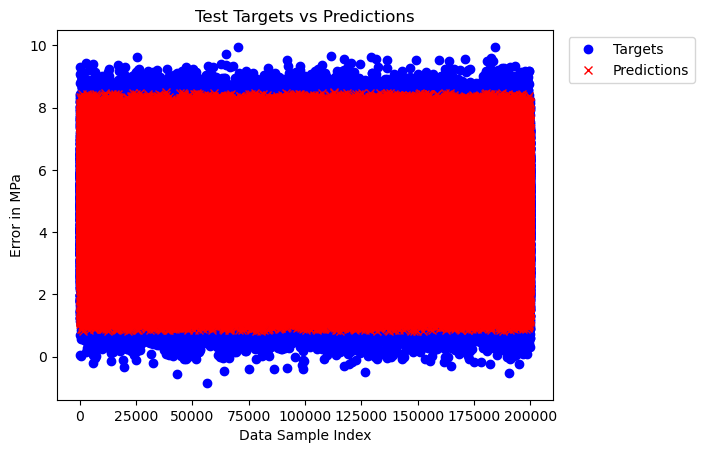

Weights:
[ 4.65045201e+00  1.34268992e+00 -1.33565929e+00 -8.32774876e-01
  4.67853708e-05  5.27260184e-05 -4.01237660e-05 -4.29787828e-05
 -9.03512963e-06  2.16155674e-04 -6.61207115e-05 -5.47458748e-05
  4.42346389e-05 -1.22986193e-04  6.39109669e-05 -5.02408492e-05
 -2.55237498e-05  1.41115558e-04 -1.28509153e-05 -1.27984928e-04
 -7.50003331e-02  7.49993286e-02 -5.99338530e-02  5.99255787e-02
 -5.04705042e-05  9.93445878e-05 -3.14501814e-05 -3.17888046e-01
  6.77775059e+00  3.79164070e+00  4.22578551e-05  6.57049238e-05
 -3.46186624e-05 -5.45468709e-05 -1.43219615e-05  2.15939983e-04
 -5.55340628e-05 -5.06476185e-05  3.66775818e-05 -1.21951669e-04
  6.17556366e-05 -4.37837660e-05 -3.75119038e-05  1.46110179e-04
 -1.90296364e-05 -1.26130577e-04 -7.49984152e-02  7.49946387e-02
 -5.99189745e-02  5.99292014e-02 -5.44120489e-05  9.89034343e-05
 -2.46310298e-05  7.80628202e-01 -1.18467953e+01 -6.62311263e+00
  4.13209872e-05  6.21631630e-05 -3.62678598e-05 -5.59883882e-05
 -1.31603861e-05

In [14]:
X_trn, y_trn, _, _, X_tst, y_tst = get_preprocessed_data(
    degree=5
)

rols = RidgeOrdinaryLeastSquares(lamb = 0.00006)
rols.fit(X_trn, y_trn)
y_hat_tst = rols.predict(X_tst)
test_mse = mse(y_tst, y_hat_tst)
print("mse: ",test_mse)
test_rmse = rmse(y_tst, y_hat_tst)
print("rmse: ",test_rmse)

plt.plot(y_tst, 'ob', label='Targets')
plt.plot(y_hat_tst, 'xr', label='Predictions')
plt.xlabel("Data Sample Index")
plt.ylabel("Error in MPa")
plt.title("Test Targets vs Predictions")
plt.legend()
plt.legend(bbox_to_anchor=(1.3, 1.00))
plt.show()

print(f"Weights:\n{rols.w.flatten()}")

In [15]:
def get_batches(
    data_len: int, 
    batch_size: int = 32,
) -> List[np.ndarray]:
    """ Generates mini-batches based on the data indexes
        
        Args:
            data_len: Length of the data or number of data samples 
                in the data. This is used to generate the indices of
                the data.
            
            batch_size: Size of each mini-batch where the last mini-batch
                might be smaller than the rest if the batch_size does not 
                evenly divide the data length.

        Returns:
            A list of NumPy array's holding the indices of batches
    """
    indices = np.arange(data_len)
    np.random.shuffle(indices)
    batches = [indices[i:i+batch_size] for i in range(0, data_len, batch_size)]

    return batches

In [16]:
class RidgeLeastMeanSquares():
    """ Performs ridge regression using least mean squares (gradient descent)
    
        Attributes:

            alpha: learning rate or step size

            lamb (float): Regularization parameter for controlling
                L2 regularization.
                
            batch_size: Size of mini-batches for mini-batch gradient
                descent.
            
            epochs: Number of epochs to run for mini-batch
                gradient descent
                
            seed: Seed to be used for NumPy's RandomState class
                or universal seed np.random.seed() function.

            w: 1D vector of weights 

            trn_error: Stores the training error for each epoch.

            vld_error: Stores the validation error for each epoch.
    """

    def __init__(
        self, 
        alpha: float,
        lamb: float, 
        batch_size: int,
        seed: int = 0,
        epochs: int = 1,
    ):
        self.alpha = alpha
        self.lamb = lamb
        self.batch_size = batch_size
        self.epochs = epochs
        self.seed = seed
        self.w = None
        self.trn_error = None
        self.vld_error = None
    
    def fit(
         self, X: np.ndarray, 
         y: np.ndarray, 
         X_vld: np.ndarray=None, 
         y_vld: np.ndarray=None
     ) -> object:
        """ Train LMS to learn weights

            Args:
                X: Training data given as a 2D matrix

                y: Training labels given as a 2D column vector
                
            Returns:
                The class's own object reference. 
        """
        np.random.seed(self.seed)
        self.trn_error = []
        self.vld_error = []
        self.w = np.random.rand(X.shape[1],1)
        self.lamb = np.full(self.w.shape, self.lamb)
        self.lamb[0] = 0 
        for e in range(self.epochs):
            batches = get_batches(len(X), batch_size=self.batch_size)
            
            for i in batches:
                X_batch = X[i]
                y_batch = y[i]
                preds = self.predict(X[i])
                error = preds - y[i]
                mean_grad = (np.dot(X_batch.T, error) / len(X_batch)) + self.lamb * self.w
                self.w -= mean_grad * self.alpha
        
            trn_preds = self.predict(X)
            trn_error = rmse(y, trn_preds)
            self.trn_error.append(trn_error)
    
            if X_vld is not None and y_vld is not None:
                vld_preds = self.predict(X_vld)
                vld_error = rmse(y_vld, vld_preds)
                self.vld_error.append(vld_error)
        return self
    
    def predict(self, X: np.ndarray) -> np.ndarray:
        """ Make predictions using learned weights

            Args:
                X: Testing data given as a 2D matrix

            Returns:
                A 2D column vector of predictions for each data sample in X
        """
        return np.dot(X, self.w)

Test y_hat shape: (200000, 1)
Test RMSE: 0.5036426801495182
Adjusted R2: 0.911968825959316


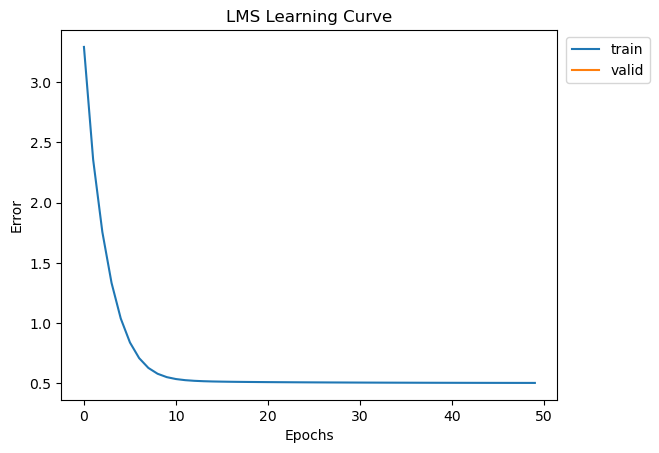

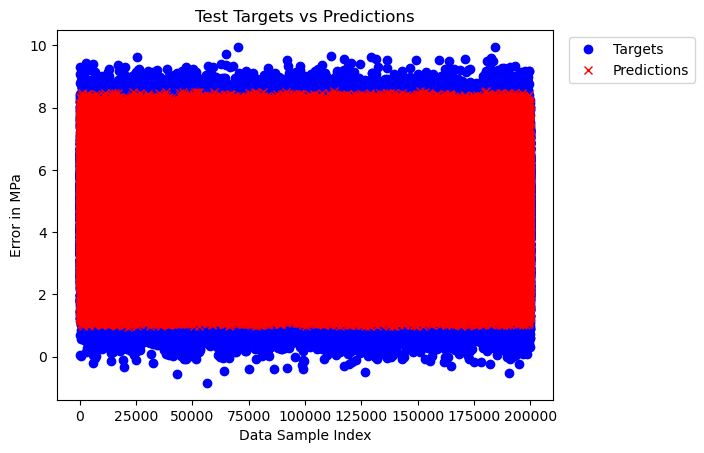

Weights:
[ 4.65056073e+00  9.65980592e-01  1.45271703e-01  1.29542034e-01
  1.55223097e-01  3.04212757e-01  2.32407525e-01  5.44472503e-01
  4.66502273e-01  6.37733952e-01  4.56174446e-02  1.03159093e+00
  8.90698338e-01  2.72225578e-01  3.35085508e-01  1.27266172e-01
  4.63066585e-01  2.50611779e-01  3.89759003e-01  3.51345180e-01
  5.96768032e-01  1.54567566e-01  2.60047759e-01  3.98448954e-01
  4.16196441e-01  8.38331072e-01  1.86356350e-01  2.63518659e-01
 -5.08216076e-02 -4.80988902e-01  6.06742604e-01  3.18742145e-01
  2.39375402e-01  6.27180666e-01  8.31013882e-01  7.38057232e-01
  3.29642502e-01  1.59366145e-01  7.42490924e-01  5.00035578e-01
  2.75299664e-01  4.39033942e-01  1.93216871e-01  6.35170039e-01
  2.16596537e-01  7.22632810e-01  2.96630670e-01  5.35136075e-01
  5.14609609e-01  2.16944262e-01  9.29703458e-01  8.28288083e-01
  9.26170523e-01  4.69235506e-01 -9.01504762e-02  3.45301805e-01
  8.76979616e-02  3.44200505e-01  2.19551393e-01  3.63471968e-03
  2.54067706e-01

In [23]:
from sklearn.metrics import mean_squared_error, r2_score

X_trn, y_trn, X_vld, y_vld, X_tst, y_tst = get_preprocessed_data(
    degree=4
)

rlms = RidgeLeastMeanSquares(
        lamb=0.000001,
        alpha=.099, 
        batch_size=300000, 
        epochs=50,
        seed=42
)
rlms.fit(X_trn, y_trn)
y_hat_tst = rlms.predict(X_tst)
print(f"Test y_hat shape: {y_hat_tst.shape}")
tst_rmse = rmse(y_tst, y_hat_tst)
print(f"Test RMSE: {tst_rmse}")

r2 = r2_score(y_tst, y_hat_tst)
adjusted_r2 = 1 - (1 - r2) * ((len(y_tst) - 1) / (len(y_tst) - X_tst.shape[1] - 1))
print(f"Adjusted R2: {adjusted_r2}")

plt.plot(rlms.trn_error, label='train')
plt.plot(rlms.vld_error, label='valid')
plt.title("LMS Learning Curve")
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.legend(bbox_to_anchor=(1.2, 1.00))
plt.show()

plt.plot(y_tst, 'ob', label='Targets')
plt.plot(y_hat_tst, 'xr', label='Predictions')
plt.xlabel("Data Sample Index")
plt.ylabel("Error in MPa")
plt.title("Test Targets vs Predictions")
plt.legend()
plt.legend(bbox_to_anchor=(1.3, 1.00))
plt.show()

print(f"Weights:\n{rlms.w.flatten()}")